# Download the Data

In [2]:
import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path

import boto3
import sagemaker

from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']


In [3]:
def download(download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print(f'Downloading {target_file} ...')
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
        else:
            print(f'Already downloaded {target_file}')

def extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        target_dir = target_file.replace('.tar.gz', '')
        assert target_file in os.listdir(download_dir), f'{target_file} not found in {download_dir}'
        if target_dir not in os.listdir(data_dir):
            print(f'Extracting {target_file} ...')
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print(f'Already extracted {target_file}')


Path('data').mkdir(parents=True, exist_ok=True)

download('.')
extract('data', '.')


Already downloaded images.tar.gz
Already downloaded annotations.tar.gz
Already extracted images.tar.gz
Already extracted annotations.tar.gz


# Visualize Data

Even thought the "annotations" directory have more masks (`.png`) than the actual images (`.jpg`) in the "images" directory, we'll only use the ones we need (the ones we have the `.jpg` for).

The structure of the files is like `image_name.jpg` and then the mask with the same name but with a `.png` extension.

In [4]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(f"num of masks: {len(maps)}")


num of masks: 14780


In [5]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(f"num of images:{len(images)}")


num of images:7390


In [6]:
images[5]


'german_shorthaired_89.jpg'

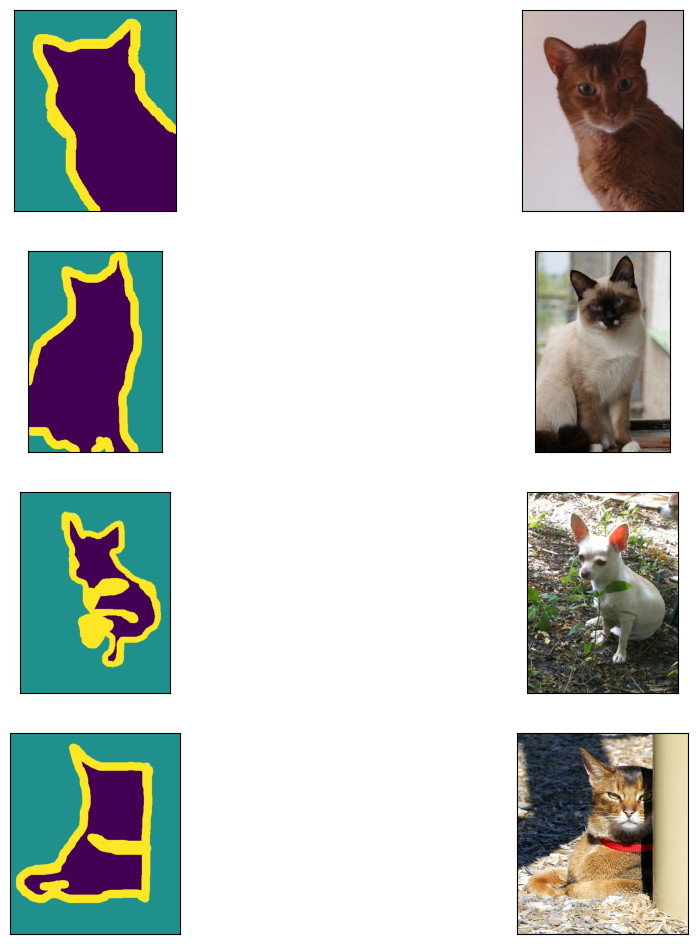

In [7]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()


In [8]:
# number of classes in the mask
# a class for background, a class for the object (forground), and a class for the object boundary (or also known as niether region)
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))


[1 2 3]


# SageMaker Setup

In [9]:
# create a sagemaker role
role = sagemaker.get_execution_role()

# A bucket is a fundamental storage container within AWS Simple Storage Service (S3).
# A bucket provides a secure and scalable way to store and retrieve any amount of data from anywhere on the web.
# You need to create the S3 bucket (from the AWS website) before you can use it.
# note that the bucket name must be unique across all AWS accounts (not just your account)!
bucket_name = "petdatamy"
# boto3.resource('s3').create_bucket(Bucket=bucket_name,
#                           CreateBucketConfiguration={
#                               'LocationConstraint': boto3.Session().region_name
#                               })

# we'll be using the sagemaker's built-in semantic segmentation algorithm
# the algorithm is a pre-built container that is hosted on Amazon Elastic Container Registry (ECR)
# the `training_image`, refers to the URI of the container image that contains the algorithm
# `boto3.Session().region_name` is the region where the algorithm is hosted
training_image = sagemaker.image_uris.retrieve(
    framework='semantic-segmentation', 
    region=boto3.Session().region_name, 
    version='latest',
    )

print(f"Training image: {training_image}")


[03/29/25 04:21:16] INFO     Found credentials from IAM Role:                                   ]8;id=831047;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=180985;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=911170;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=202441;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=257031;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=634927;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Training image: 825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [10]:
# train -> holds training images
# validation -> holds validation images

# train_annotation -> holds training trimaps (masks)
# validation_annotation -> holds validation trimaps (masks)

pre = Path('local_bucket')
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    folder = pre / folder
    # uncomment to delete local_bucket
    shutil.rmtree(folder) if folder.exists() else None
    folder.mkdir(parents=True, exist_ok=True)


# Preparing Data for SageMaker
We move the dataset to AWS Bucket for the SageMaker to work on.

In [11]:
def get_map_file(image):
    """get the trimap for a given image"""
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file


# if images exist in the local bucket, we skip the loop to prevent a messy copy
# delete the local bucket if you want to split and copy all images again
if len(set((pre / 'train').iterdir())) > 0:
    print(f'Images exists in {pre}')
else:
    for image in tqdm(images):
        # randomly assign 75% of the images to the training set and 25% to the validation set
        # since we are looping over each image once, there is no need to prevent duplicates
        # note that this random assignment doesn't guarantee exactly 75% / 25% split!
        # It's probabilistic, so we might get slightly different proportions each time the code runs
        target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
        
        # constructing the image path
        image_file_path = Path('data/images') / image
        image_target_path = pre / target_set / image  # for the local bucket
        
        # constructing the trimap path
        map_file_path = Path(trimaps_dir) / get_map_file(image)
        map_target_path = pre / (target_set + '_annotation') / get_map_file(image)  # for the local bucket
        
        # copying the images to the target directories
        shutil.copy(image_file_path, image_target_path)
        shutil.copy(map_file_path, map_target_path)


100%|██████████| 7390/7390 [00:19<00:00, 382.73it/s]


In [12]:
train_images = set((pre / 'train').iterdir())
train_annots = set((pre / 'train_annotation').iterdir())

print(f"{len(train_annots)=}, \n{len(train_images)=}")

len(train_annots)=5570, 
len(train_images)=5570


# Uploading Data to S3

Technically, S3 doesn't have any folder structure.
It uses a flat namespace to store the objects.
However, the S3 console displays the objects in a folder-like structure by using prefixes.
when we specify a prefix, S3 will create a virtual folder structure for us.

In [21]:
sess = sagemaker.Session()

upload = True  # set to True to upload the data to S3

if upload:
    # delete the content of the session bucket before uploading new data
    sess.boto_session.resource('s3').Bucket(bucket_name).objects.all().delete()
    
    print("Starting uploading to S3 ...")
    print("Uploading train images ...")

    s3_train_path = sess.upload_data(path=pre/'train', bucket=bucket_name, key_prefix='train') 

    print("Uploading train annotation ...")
    s3_train_annotation_path = sess.upload_data(path=pre/'train_annotation', bucket=bucket_name, key_prefix='train_annotation')

    print("Uploading validation images ...")
    s3_val_path = sess.upload_data(path=pre/'validation', bucket=bucket_name, key_prefix='validation')

    print("Uploading validation annotation ...")
    s3_val_annotation_path = sess.upload_data(path=pre/'validation_annotation', bucket=bucket_name, key_prefix='validation_annotation')

    print(f"Finished uploading to S3")


[03/29/25 04:30:51] INFO     Found credentials from IAM Role:                                   ]8;id=518088;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=753002;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Starting uploading to S3 ...
Uploading train images ...
Uploading train annotation ...
Uploading validation images ...
Uploading validation annotation ...
Finished uploading to S3


In [22]:
s3_train_path

's3://petdatamy/train'

# SageMaker Estimator

In [25]:
model_api = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    sagemaker_session=sess,

    instance_count=1,  # number of GPUs
    
    # note that the instance type must be compatible with the algorithm
    instance_type='ml.p3.2xlarge', # 16 GB GPU machine

    # The size of the EBS (Elastic Block Store) volume that will be attached to the instance
    volume_size=100,  # in GB

    # Upper limit of the time that the model can run for
    max_run=36_000,  # in seconds

    # the mode that the input data is stored in the bucket
    input_mode='File',

    output_path=f's3://{bucket_name}/output',  # where the trained (model) artifacts will be stored
)

# Hyperparameters

**What is Pacemaker?**

an open-source high availability (HA) resource manager that AWS uses to orchestrate and manage the availability of SAP applications and databases, ensuring minimal downtime in case of failures

In [36]:
model_api.set_hyperparameters(
    backbone='resnet-50',
    use_pretrained_model=True,  # pretrained on the ImageNet dataset
    algorithm='fcn', # Fully Convolutional Network
    crop_size=240,  # the size of the input images
    
    # the number of classes in the dataset.
    # eventhough we have 3 classes, our trimaps classes are not 0-2 but 1-3
    # so we have 2 options: either we change all the trimap pngs to 0-2, or we set the num_classes to 4
    # and hope the algorithm will learn to ignore class zero.
    num_classes=4,
    num_training_samples=len(train_images),

    epochs=10,
    learning_rate=0.001,
    optimizer='rmsprop', # adam, sgd, or rmsprop
    lr_scheduler='poly',  # step, cosine, or poly
    # weight_decay=0.0001,

    mini_batch_size=16,
    validation_mini_batch_size=16,

    # early_stopping=True,
    # early_stopping_patience=5,
    # early_stopping_metric='validation:loss',
    # early_stopping_metric_criteria='min',
)

# Data Channels

These will point to the data locations in "S3". We pass this to the model to know where to look.

In [33]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_path,
    distribution='FullyReplicated',  # the data is replicated across all instances if we are distribute training
    content_type='image/jpeg',
    # `S3Prefix` will look at the files in the directory and create the training data channel
    s3_data_type='S3Prefix',  # or S3DataTypeManifest
)

train_ann_data = sagemaker.inputs.TrainingInput(
    s3_train_annotation_path,
    distribution='FullyReplicated',
    content_type='image/png',
    s3_data_type='S3Prefix',
)

val_data = sagemaker.inputs.TrainingInput(
    s3_val_path,
    distribution='FullyReplicated',
    content_type='image/jpeg',
    s3_data_type='S3Prefix',
)

val_ann_data = sagemaker.inputs.TrainingInput(
    s3_val_annotation_path,
    distribution='FullyReplicated',
    content_type='image/png',
    s3_data_type='S3Prefix',
)


In [34]:
data_channels = {
    'train': train_data,
    'train_annotation': train_ann_data,
    'validation': val_data,
    'validation_annotation': val_ann_data
}

data_channels


{'train': <sagemaker.inputs.TrainingInput at 0x7f428a4ea860>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f428a4e8e50>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f428a4eaaa0>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f428a4e9180>}

# Model Training
Starting a training job

In [37]:
model_api.fit(inputs=data_channels, logs=True)

[03/29/25 05:16:50] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=988518;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=975468;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=84673;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=606136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             semantic-segmentation-2025-03-29-05-16-50-111                                         

2025-03-29 05:16:52 Starting - Starting the training job...
2025-03-29 05:17:15 Starting - Preparing the instances for training...
2025-03-29 05:17:48 Downloading - Downloading input data..................
2025-03-29 05:20:34 Downloading - Downloading the training image............
2025-03-29 05:22:41 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Mar 29 05:22:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap

# Deploy Model

We need to deploy the model to use it for inference

In [39]:
deployed_model = model_api.deploy(
    initial_instance_count=1,  # number of GPUs
    instance_type='ml.m4.xlarge',
    # endpoint_name='pet-segmentation-endpoint'  # optional
)

print("Model deployed!")

[03/29/25 05:46:04] INFO     Creating model with name:                                              ]8;id=241624;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=810825;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\
                             semantic-segmentation-2025-03-29-05-46-04-295                                         

                    INFO     Creating endpoint-config with name                                     ]8;id=638139;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=403438;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\
                             semantic-segmentation-2025-03-29-05-46-04-295                                         

[03/29/25 05:46:05] INFO     Creating endpoint with name                                            ]8;id=471467;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=464264;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\
                             semantic-segmentation-2025-03-29-05-46-04-295                                         

---------------!Model deployed!


# Predictions

In [42]:
image_dir = pre/'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1820


In [43]:
# specify that we are passing jpeg images
deployed_model.content_type = 'image/jpeg'

# we also specify that we are expecting png images in return
deployed_model.accept = 'image/png'

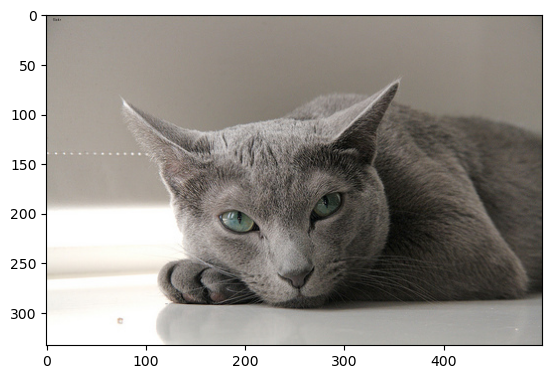

In [57]:
index = 12

# open the image
image_path = os.path.join(image_dir, images[index])
with open(image_path, 'rb') as f:
    b = bytearray(f.read())

plt.imshow(plt.imread(image_path));

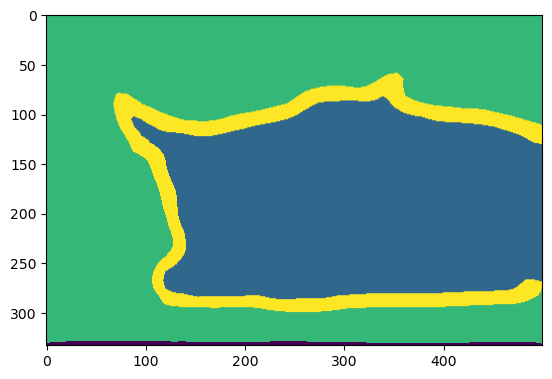

In [58]:
# predicting the mask
results = deployed_model.predict(b)

# convert the byte array to a numpy array
mask = np.array(Image.open(io.BytesIO(results)))
plt.imshow(mask);

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [60]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint_name)

[03/29/25 06:00:18] INFO     Deleting endpoint with name:                                           ]8;id=41938;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=735144;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4903\4903]8;;\
                             semantic-segmentation-2025-03-29-05-46-04-295                                         

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 sagemaker.Session().delete_endpoint(deployed_model.endpoint_name)                            │
│   2                                                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:4904 in  │
│ delete_endpoint                                                                                  │
│                                                                                                  │
│   4901 │   │   │   endpoint_name (str): Name of the Amazon SageMaker ``Endpoint`` to delete.     │
│   4902 │   │   """                                                                               │
│   4903 │   │   logger.info("Deleting endpoint with name: %s", endpoint_name)                     │
│ ❱ 4904 │   │   self.sagemaker_client.delete_endpoint(EndpointName=endpoint_name)                 │
│   4905 │                                                                                         │
│   4906 │   def delete_endpoint_config(self, endpoint_config_name):                               │
│   4907 │   │   """Delete an Amazon SageMaker endpoint configuration.                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:570 in     │
│ _api_call                                                                                        │
│                                                                                                  │
│    567 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    568 │   │   │   │   )                                                                         │
│    569 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  570 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    571 │   │                                                                                     │
│    572 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    573                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/context.py:124 in    │
│ wrapper                                                                                          │
│                                                                                                  │
│   121 │   │   │   with start_as_current_context():                                               │
│   122 │   │   │   │   if hook:                                                                   │
│   123 │   │   │   │   │   hook()                                                                 │
│ ❱ 124 │   │   │   │   return func(*args, **kwargs)                                               │
│   125 │   │                                                                                      │
│   126 │   │   return wrapper                                                                     │
│   127                                                                                            │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-p